# Building decision trees

Well, actually, we'll fake finding optimal split as that is your project.

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes, fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

from sklearn import tree
from dtreeviz.trees import *

## One possible tree framework

In [2]:
from lolviz import *

class DecisionNode:
    def __init__(self,split): # split chosen from x values
        self.split = split

class LeafNode:
    def __init__(self,y):
        self.y = y

## 1D decision tree stumps

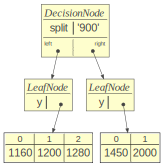

In [3]:
root = DecisionNode(900)                 # split on x at 900
root.left = LeafNode([1160, 1200, 1280]) # 3 y values in leaf
root.right = LeafNode([1450,2000])
treeviz(root)

In [4]:
df = pd.DataFrame()
df["sqfeet"] = [750, 800, 850, 900,950]
df["rent"] = [1160, 1200, 1280, 1450,1300]
df

,sqfeet,rent
0,750,1160
1,800,1200
2,850,1280
3,900,1450
4,950,1300


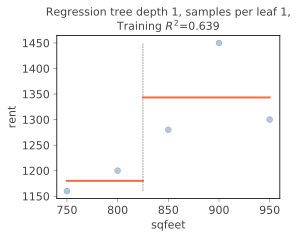

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))
X, y = df.sqfeet.values, df.rent.values
t = rtreeviz_univar(ax,
                    X, y,
                    max_depth=1,
                    feature_name='sqfeet',
                    target_name='rent',
                    fontsize=11,
                    colors={'scatter_edge': 'black'})

In [6]:
def fit(x, y):
    """
    We train on the (x,y), getting split of single-var x that
    minimizes variance in subregions of y created by x split.
    Return root of decision tree stump
    """
    split = find_best_split(x,y)
    root = DecisionNode(split)
    root.left = LeafNode(y[x<split])
    root.right = LeafNode(y[x>=split])
    return root

def find_best_split(x,y):
    "Fake it by picking random value from x (ignoring y)"
    i = np.random.randint(0, len(x))
    return x[i]

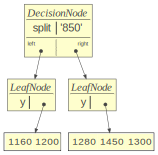

In [7]:
t = fit(X, y)
treeviz(t)

## 1D decision tree

In [8]:
def fit(x, y):
    """
    We train on the (x,y), getting split of single-var x that
    minimizes variance in subregions of y created by x split.
    Return root of decision tree stump
    """
    if len(x)==1:
        return LeafNode(y)
    split = find_best_split(x,y)
    if np.sum(x<split)==0 or np.sum(x>=split)==0: # don't allow empty subregion(s)
        return LeafNode(y)
    t = DecisionNode(split)
    t.left  = fit(x[x<split],  y[x<split])
    t.right = fit(x[x>=split], y[x>=split])
    return t

def find_best_split(x,y):
    "Fake it by picking random value from x (ignoring y)"
    if len(x)<1:
        return np.inf # can't split a single value
    i = np.random.randint(0, len(x))
    return x[i]

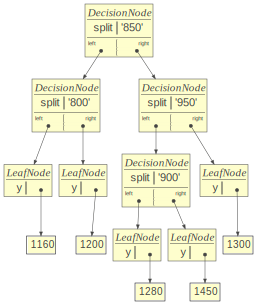

In [9]:
t = fit(X, y)
treeviz(t)

### Tree structure

n=506


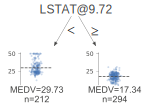

In [10]:
boston = load_boston()
X = boston.data
y = boston.target
features = boston.feature_names
print(f"n={len(y)}")

t = DecisionTreeRegressor(min_samples_leaf=200)
t.fit(X,y)
dtreeviz(t,
       X,
       y,
       target_name='MEDV',
       feature_names=features,
         fancy=False)

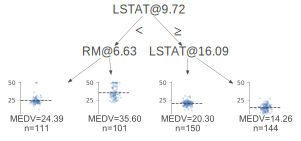

In [11]:
t = DecisionTreeRegressor(min_samples_leaf=100)
t.fit(X,y)
dtreeviz(t,
       X,
       y,
       target_name='MEDV',
       feature_names=features,
         fancy=False)

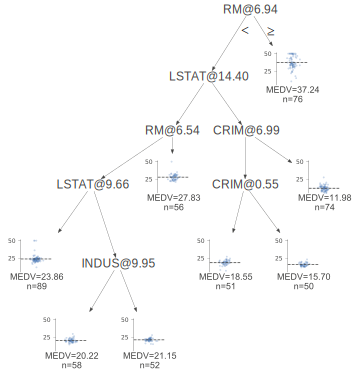

In [12]:
t = DecisionTreeRegressor(min_samples_leaf=50)
t.fit(X,y)
dtreeviz(t,
       X,
       y,
       target_name='MEDV',
       feature_names=features,
         fancy=False)

## Min samples per leaf

### Regression

In [13]:
# can't use too many records as model.score() will be average of many values
# which reduces variance; we're trying to highlight not hide that variance
df_rent = pd.read_csv("data/rent-ideal.csv", nrows=500)
X = df_rent[['bedrooms','bathrooms','latitude','longitude']]
y = df_rent['price']
X.head()

FileNotFoundError: [Errno 2] File b'data/rent-ideal.csv' does not exist: b'data/rent-ideal.csv'

In [ ]:
ntrials = 20
n = len(X)
ntrain = int(n * 0.8)
ntest = n - ntrain
# leaf_sizes = list(range(1, n, n // n_hyperparameters))
leaf_sizes = [1,2,3,5,10,20,30,50,75,90,100,110,125,150,200,300,400,425,450,500]
all_train_scores = np.zeros(shape=(ntrials, len(leaf_sizes)))
all_test_scores = np.zeros(shape=(ntrials, len(leaf_sizes)))

print("Trial: ", end='')
for i in range(ntrials):
    print(f"{i} ", end='')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    train_scores = []
    test_scores = []
    for m in leaf_sizes:
        t = DecisionTreeRegressor(min_samples_leaf=m)
        t.fit(X_train, y_train)
        mae = mean_absolute_error(y_test, t.predict(X_test))
        s = t.score(X_test, y_test)
        train_s = t.score(X_train, y_train)
        test_scores.append(s)
#         test_scores.append(mae)
        train_scores.append(train_s)
#         print(f"samples / leaf = {m:5d}, score is {s:.2f}")
    all_test_scores[i] = test_scores
    all_train_scores[i] = train_scores

In [ ]:
test_means = np.mean(all_test_scores, axis=0)
test_variances = np.std(all_test_scores, axis=0)
train_variances = np.std(all_train_scores, axis=0)
test_variances

In [ ]:
figsize = (4,2.8)
fig, ax = plt.subplots(1, 1, figsize=figsize)
# a = ax.errorbar(leaf_sizes, 1-test_scores, yerr=test_variances*3,
#                 uplims=True, lolims=True, elinewidth=.5,
#                 lw=1, label="test set 1 - R^2")

a = ax.plot(leaf_sizes, 1-test_means, lw=.75, marker='.', label="test set 1 - R^2")

plt.fill_between(leaf_sizes, 
                 1-test_means - test_variances,
                 1-test_means + test_variances,
                 color='gray', alpha=0.2)

ax2 = ax.twinx()
b = ax2.plot(leaf_sizes, test_variances, lw=1, label="test set stdev", c='orange')
ax2.yaxis.label.set_color('orange')
ax2.tick_params(axis='y', colors='orange')
ax2.set_ylim(-0.002,0.14)

ax.set_xlabel("Samples per leaf")
ax.set_ylabel("1-R^2")
ax.set_ylim(-.05,1.1)
lines = a+b
labels = [l.get_label() for l in lines]
ax.legend(lines,labels,loc='center right')

ax.set_title("NYC Rent test error, stddev versus leaf size", fontsize=10)

In [ ]:
figsize = (4,2.8)
fig, ax = plt.subplots(1, 1, figsize=figsize)
# a = ax.errorbar(leaf_sizes, 1-test_scores, yerr=test_variances*3,
#                 uplims=True, lolims=True, elinewidth=.5,
#                 lw=1, label="test set 1 - R^2")

a = ax.plot(leaf_sizes, 1-test_means, lw=.75, marker='.', label="train set 1 - R^2")

plt.fill_between(leaf_sizes, 
                 1-test_means - train_variances,
                 1-test_means + train_variances,
                 color='gray', alpha=0.2)

ax2 = ax.twinx()
b = ax2.plot(leaf_sizes, test_variances, lw=1, label="train set stdev", c='orange')
ax2.yaxis.label.set_color('orange')
ax2.tick_params(axis='y', colors='orange')
ax2.set_ylim(-0.002,0.14)

ax.set_xlabel("Samples per leaf")
ax.set_ylabel("1-R^2")
ax.set_ylim(-.05,1.1)
lines = a+b
labels = [l.get_label() for l in lines]
ax.legend(lines,labels,loc='center right')

ax.set_title("NYC Rent training error, stddev versus leaf size", fontsize=10)

### Classification

In [ ]:
digits = load_digits()

df_digits = pd.DataFrame(data=digits.data)
df_digits['digit'] = digits.target
df_digits = df_digits.sample(n=500)
X = df_digits.drop('digit', axis=1)
y = df_digits['digit']

In [ ]:
ntrials = 10
n_hyperparameters = 30
n = len(X)
ntrain = int(n * 0.8)
leaf_sizes = list(range(1, int(n*.6), n // n_hyperparameters))
all_train_scores = np.zeros(shape=(ntrials, len(leaf_sizes)))
all_test_scores = np.zeros(shape=(ntrials, len(leaf_sizes)))

for i in range(ntrials):
    print(f"Trial {i}")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    train_scores = []
    test_scores = []
    for m in leaf_sizes:
        t = DecisionTreeClassifier(min_samples_leaf=m)
        t.fit(X_train, y_train)
        s = t.score(X_test, y_test)
        train_s = t.score(X_train, y_train)
        test_scores.append(s)
        train_scores.append(train_s)
#         print(f"samples / leaf = {m:5d}, score is {s:.2f}")
    test_scores = np.array(test_scores)
    train_scores = np.array(train_scores)
    all_test_scores[i] = test_scores
    all_train_scores[i] = train_scores

In [ ]:
test_means = np.mean(all_test_scores, axis=0)
test_variances = np.std(all_test_scores, axis=0)
train_variances = np.std(all_train_scores, axis=0)
test_variances

In [ ]:
figsize = (4,2.8)
fig, ax = plt.subplots(1, 1, figsize=figsize)
a = ax.plot(leaf_sizes, 1-test_means, lw=.75, marker='.', label="test set error")

plt.fill_between(leaf_sizes,
                 1-test_means - test_variances,
                 1-test_means + test_variances,
                 color='gray', alpha=0.2)

ax2 = ax.twinx()
b = ax2.plot(leaf_sizes, test_variances, lw=1, label="test set stdev", c='orange')
ax2.yaxis.label.set_color('orange')
ax2.tick_params(axis='y', colors='orange')
ax2.set_ylabel("Stdev of error")
ax2.set_ylim(-0.002,0.1)

ax.set_xlabel("Samples per leaf")
ax.set_ylabel("Error (1-Accuracy)")
ax.set_ylim(-.03,1.0)

lines = a+b
labels = [l.get_label() for l in lines]
ax.legend(lines,labels,loc='center right')

ax.set_title("MNIST digits error, stddev versus leaf size", fontsize=10)

## Error sources diagrams

Text(0.5, 1.0, 'Perfect $y = f(X) = (X-2)^2$ data')

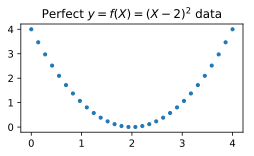

In [114]:
X = np.linspace(0,4,30)
y = (X-2)**2
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10)
ax.set_title("Perfect $y = f(X) = (X-2)^2$ data")

Text(0.5, 1.0, 'Inconsistent $y = f(X) = (X-2)^2$ data')

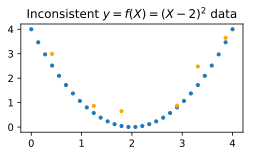

In [126]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10)
for i in [3,9,13,21,24,28]:
    ax.scatter([X[i]],[y[i]+np.random.rand()],s=10,c='orange')
ax.set_title("Inconsistent $y = f(X) = (X-2)^2$ data")

In [134]:
X = np.linspace(0,4,30)
y = (X-2)**2 + np.random.random(size=len(X))*1.5
y_ = (X-2)**2 + np.random.random(size=len(X))*1.5

Text(0.5, 1.0, 'Noisy $y = f(X) = (X-2)^2 + \\epsilon$ data')

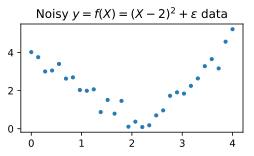

In [135]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10,c='#2679B2')
ax.set_title("Noisy $y = f(X) = (X-2)^2 + \epsilon$ data")

Text(0.5, 1.0, 'Underfit (shallow) decision tree')

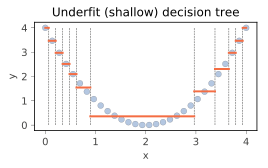

In [157]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
t = rtreeviz_univar(ax,
                    X, (X-2)**2,
                    max_depth=4,
                    feature_name='x',
                    target_name='y',
                    fontsize=10,
                    colors={'scatter_edge': 'black'},
                   show=['splits'])
ax.set_title("Underfit (shallow) decision tree")

Text(0.5, 1.0, 'Noisy data (shallow) decision tree')

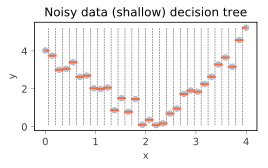

In [159]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
t = rtreeviz_univar(ax,
                    X, y,
                    max_depth=10,
                    feature_name='x',
                    target_name='y',
                    fontsize=10,
                    colors={'scatter_edge': 'black'},
                   show=['splits'])
ax.set_title("Noisy data (shallow) decision tree")

Text(0.5, 1.0, 'Underfit')

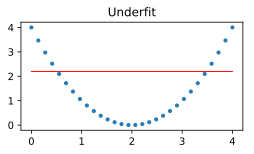

In [137]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,(X-2)**2,s=10,c='#2679B2')
ax.plot([0,4], [np.mean(y)]*2, c='red',lw=1)
ax.set_title("Underfit")

Text(0.5, 1.0, 'Underfit')

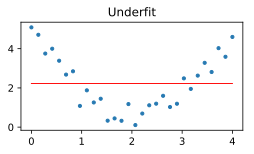

In [112]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10,c='#2679B2')
ax.plot([0,4], [np.mean(y)]*2, c='red',lw=1)
ax.set_title("Underfit")

Text(0.5, 1.0, 'Balanced model')

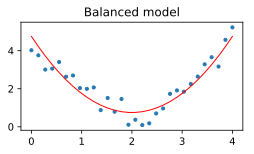

In [149]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10,c='#2679B2')
ax.plot(X,(X-2)**2+.75, c='red',lw=1)
ax.set_title("Balanced model")

Text(0.5, 1.0, 'Overfit model')

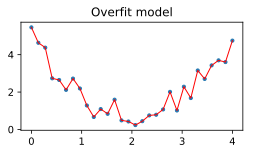

In [102]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10,c='#2679B2')
ax.plot(X,y,c='red',lw=1)
ax.set_title("Overfit model")